### Load Libraries

In [1]:
import os, sys
project_home = "/Users/pitehrhurtado/Documents/Operation-Researchs/clustering_and_discretization_OLD/src/"
if project_home not in sys.path:
    sys.path = [project_home] + sys.path

In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd

import logging

##### Configs

In [3]:
logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO)

In [4]:
# pd.set_option("display.max_columns", None)
# pd.set_option("display.max_rows", None)

### Load Data
#### A. grid data

In [5]:
grid_df = gpd.read_file("../data/geodf.geojson")

#### B. pixel data

In [6]:
df = pd.read_csv("../data/output_layer_process.csv")

## Aggregation Process

In [7]:
from app.aggregations.pixel import Meta_Pixel, Pixel
from shapely.geometry import Polygon
from matplotlib import pyplot as plt
import geopandas as gpd

In [8]:
LAYER_SELECTED = 0

In [9]:
df_used = df[df.layer == LAYER_SELECTED].reset_index(drop=True)

In [10]:
merged_df = grid_df.merge(df_used,
                         left_on="cell_id",
                         right_on="pixel",
                         how="left")
merged_df["demand_daily"] = merged_df["demand_daily"].fillna(0)
merged_df["pixel"] = merged_df.apply(lambda x: x["pixel"] if not x["pixel"] else x["cell_id"], axis=1)

In [11]:
merged_df

,cell_id,geometry,year,month,cod_customer,lat,lon,demand,n_dates,demand_daily,layer,pixel
0,0,"POLYGON ((-68.17297 -16.60097, -68.16360 -16.6...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0
1,1,"POLYGON ((-68.16360 -16.60097, -68.15423 -16.6...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,1
2,2,"POLYGON ((-68.15423 -16.60097, -68.14486 -16.6...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,2
3,3,"POLYGON ((-68.14486 -16.60097, -68.13549 -16.6...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,3
4,4,"POLYGON ((-68.13549 -16.60097, -68.12612 -16.6...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,4
...,...,...,...,...,...,...,...,...,...,...,...,...
2990,299,"POLYGON ((-68.06989 -16.43832, -68.06052 -16.4...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,299
2991,300,"POLYGON ((-68.06052 -16.43832, -68.05115 -16.4...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,300
2992,301,"POLYGON ((-68.05115 -16.43832, -68.04178 -16.4...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,301
2993,302,"POLYGON ((-68.04178 -16.43832, -68.03240 -16.4...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,302


In [12]:
## Create Pixel Object
pixels = {}
for element in merged_df.to_dict(orient="records"):
    if element["pixel"] in pixels:
        pixels[element['pixel']].add_customer(element)
    else:
        init = {
            "id": element["pixel"],
            "corner_down_left": list(element["geometry"].exterior.coords)[3],
            "corner_down_right": list(element["geometry"].exterior.coords)[2],
            "corner_up_right": list(element["geometry"].exterior.coords)[1],
            "corner_up_left": list(element["geometry"].exterior.coords)[0],
            "demand_daily": element["demand_daily"]
        }
        #logger.info(f"Creating pixel {init}\n")
        pixels[element['pixel']] = Pixel(init)
logger.info(f"Total Pixel object created {len(pixels)}")

INFO:__main__:Total Pixel object created 304


In [13]:
## Logging descriptive metrics
for k, p in pixels.items():
    avg_demand = p.get_avg_demand()
    std_demand = p.get_std_demand()
    n_customers = p.get_n_customers()
    if n_customers > 0:
        logger.info(
            f"PIXEL - {k}: avg_demand: {avg_demand:.2f} - std_demand: {std_demand:.2f} - n_customers: {n_customers}"
        )

INFO:__main__:PIXEL - 42: avg_demand: 27.88 - std_demand: 9.53 - n_customers: 42
INFO:__main__:PIXEL - 71: avg_demand: 22.50 - std_demand: 5.50 - n_customers: 2
INFO:__main__:PIXEL - 72: avg_demand: 18.70 - std_demand: 2.41 - n_customers: 10
INFO:__main__:PIXEL - 73: avg_demand: 31.58 - std_demand: 13.90 - n_customers: 26
INFO:__main__:PIXEL - 88: avg_demand: 25.45 - std_demand: 7.00 - n_customers: 20
INFO:__main__:PIXEL - 104: avg_demand: 16.00 - std_demand: 0.00 - n_customers: 1
INFO:__main__:PIXEL - 106: avg_demand: 21.20 - std_demand: 5.11 - n_customers: 5
INFO:__main__:PIXEL - 111: avg_demand: 17.00 - std_demand: 0.00 - n_customers: 1
INFO:__main__:PIXEL - 115: avg_demand: 23.00 - std_demand: 0.00 - n_customers: 1
INFO:__main__:PIXEL - 116: avg_demand: 24.00 - std_demand: 0.00 - n_customers: 1
INFO:__main__:PIXEL - 120: avg_demand: 26.69 - std_demand: 10.40 - n_customers: 29
INFO:__main__:PIXEL - 121: avg_demand: 32.29 - std_demand: 13.89 - n_customers: 55
INFO:__main__:PIXEL - 12

In [14]:
pixels[200].__dict__

{'id': 200,
 'corner_down_left': (-68.09800373252476, -16.501574644042172),
 'corner_down_right': (-68.08863241659036, -16.501574644042172),
 'corner_up_right': (-68.08863241659036, -16.492538357136915),
 'corner_up_left': (-68.09800373252476, -16.492538357136915),
 'demand': [18.0, 36.0],
 'pixels_adyacent': [],
 'belong_meta_pixel': False}

In [15]:
def plot_pixels(pixels: list[Pixel], metric: str, title: str):
    polygons = []
    demands = []
    std = []
    n_customers = []
    ids = []

    for pixel in pixels:
        polygon = pixel.get_polygon()
        demand = pixel.get_avg_demand()
        std_ = pixel.get_std_demand()
        n_customer = pixel.get_n_customers()
        polygons.append(polygon)
        demands.append(demand)
        std.append(std_)
        n_customers.append(n_customer)
        ids.append(pixel.id)

    data = {"geometry": polygons,
            "demand": demands,
            "std": std,
            "n_customer": n_customers,
            "id": ids,}
    gdf = gpd.GeoDataFrame(data)

    fig, ax = plt.subplots(figsize=(10, 10))
    
    if metric != "id":
        gdf[gdf[metric] == 0].boundary.plot(ax=ax, linewidth=1, edgecolor="lightgrey")

        gdf[gdf[metric] > 0].plot(
            ax=ax,
            column=metric,
            cmap="Blues",  
            linewidth=1,
            edgecolor="lightgrey",
            legend=True,
        )
    else:
        gdf[gdf["demand"] > 0].plot(
            ax=ax,
            cmap="Blues",  
            linewidth=1,
            edgecolor="lightgrey",
            legend=True,
        )

    for idx, row in gdf[gdf[metric] > 0].iterrows():
        ax.annotate(
            text=round(row[metric],1),
            xy=(row["geometry"].centroid.x, row["geometry"].centroid.y),
            xytext=(3, 3),
            textcoords="offset points",
            ha="center",
            fontsize=8,
        )

    plt.title(f"Plot about {title} ")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")

    plt.show()


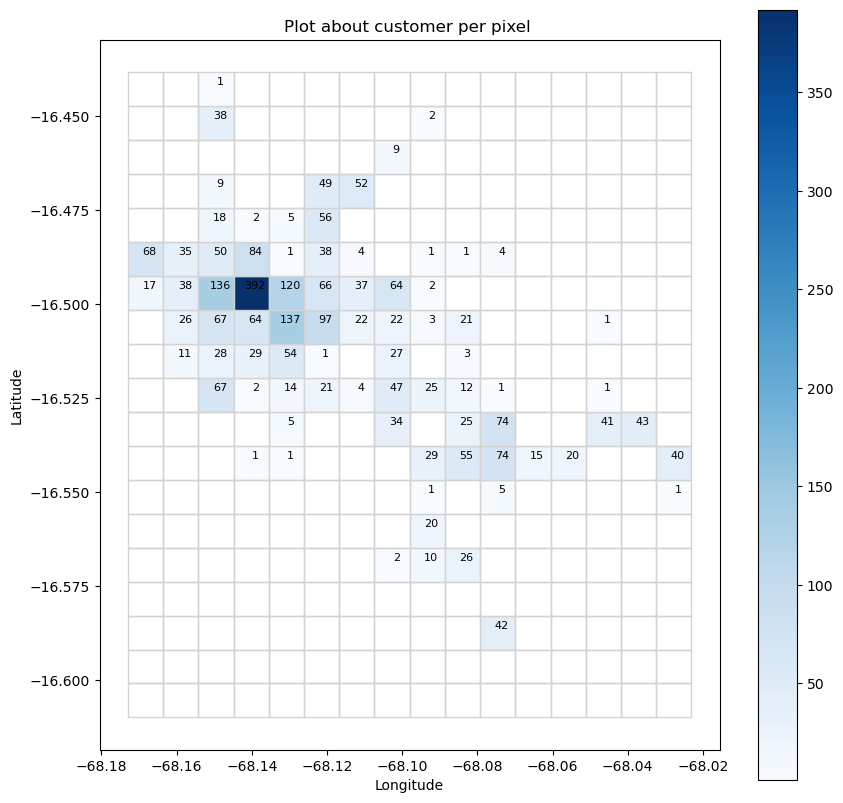

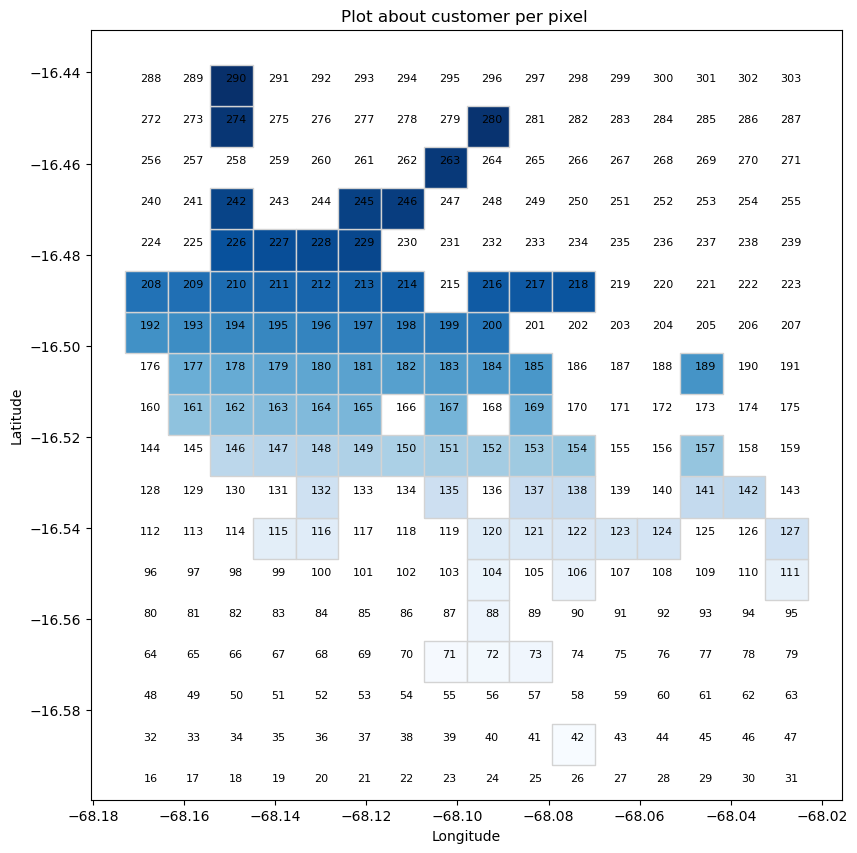

In [16]:
#plot_pixels(pixels.values(), 'demand', 'avg_demand per pixel')
#plot_pixels(pixels.values(), 'std', 'std_demand per pixel')
plot_pixels(pixels.values(), 'n_customer', 'customer per pixel')
plot_pixels(pixels.values(), 'id', 'customer per pixel')

#### agrupar:
pixels: 
- 290 + 274
- 242 + 226
- 227 + 228 + 229
- 212 + 213
- 214 + 198
- 199 + 200
- 184 + 185
- 216 + 217 + 218
- 185 + 169
- 152 + 153 + 154
- 149 + 150
- 148 + 132 + 116
- 163 + 147
- 122 + 106
- 157 + 141
- 127 + 111
- 71 + 72 + 73


In [17]:
dict_to_agg = {
    290: [274],
    242: [226],
    227: [228, 229],
    212: [213],
    214: [198],
    199: [200],
    216: [217, 218],
    185: [169],
    152: [153, 154],
    149: [150],
    148: [132, 116],
    163: [147],
    122: [106],
    157: [141],
    127: [111],
    71: [72, 73],
    104: [88],
    183: [184],
    164: [165],
}

## Proceso de agregación Manual

In [18]:
meta_pixels = []
for k,p in pixels.items():
    if k in dict_to_agg:
        new_meta_pixel = Meta_Pixel(p)
        for adj_pixel in dict_to_agg[k]:
            new_meta_pixel.add_pixel(pixels[adj_pixel])
        meta_pixels.append(new_meta_pixel)
    else:
        is_ = False
        for element in dict_to_agg.values():
            if k in element:
                is_ = True
        
        if not is_:
            meta_pixels.append(Meta_Pixel(p))
    

In [19]:
for meta in meta_pixels:
    meta.construct_meta_pixel()

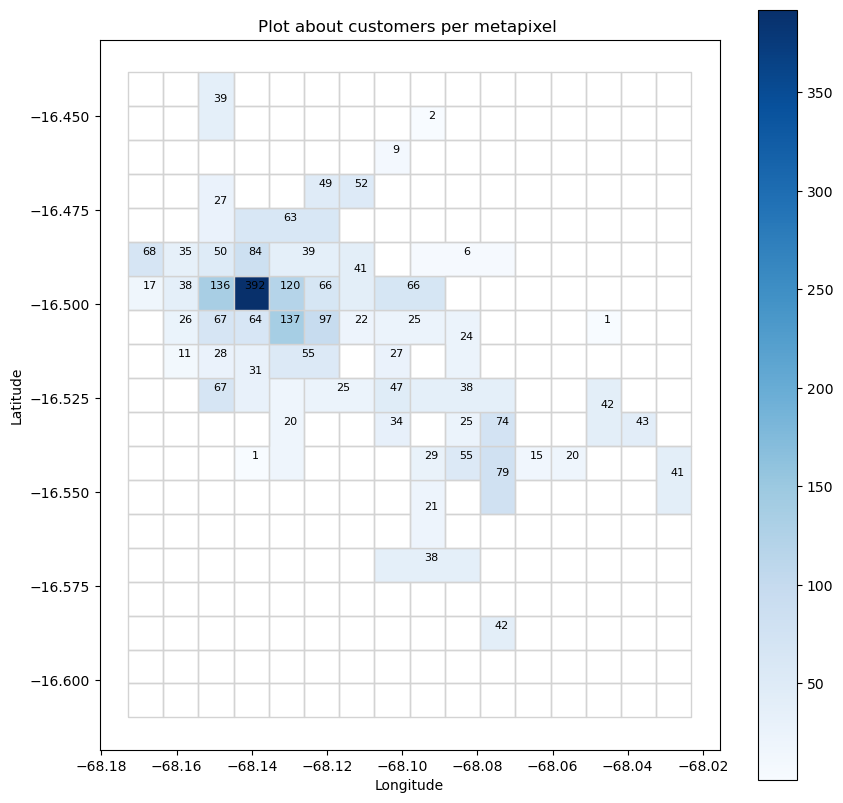

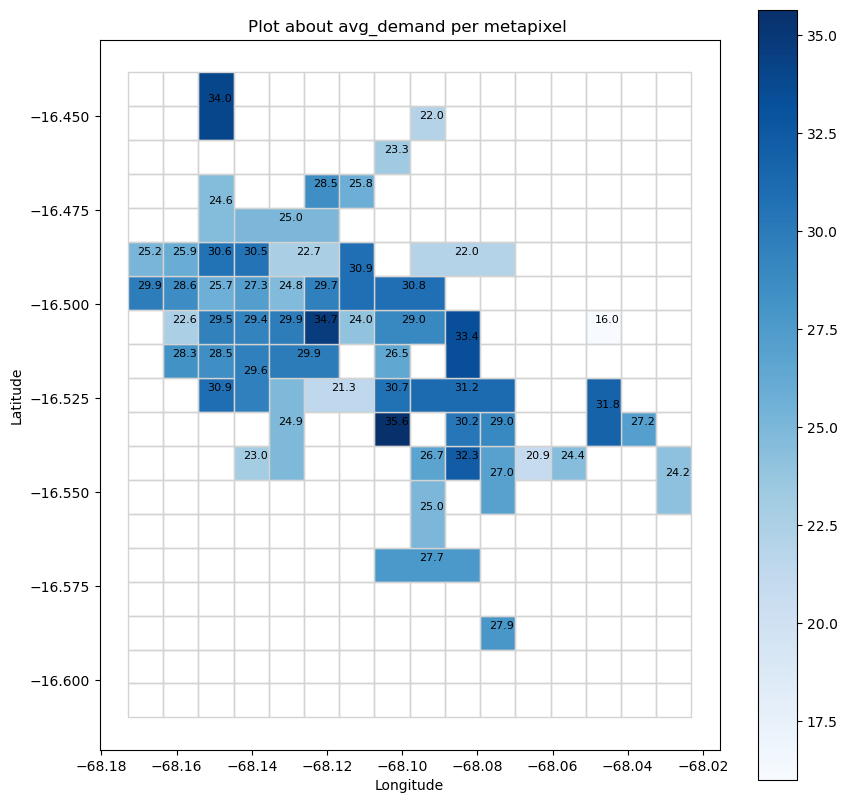

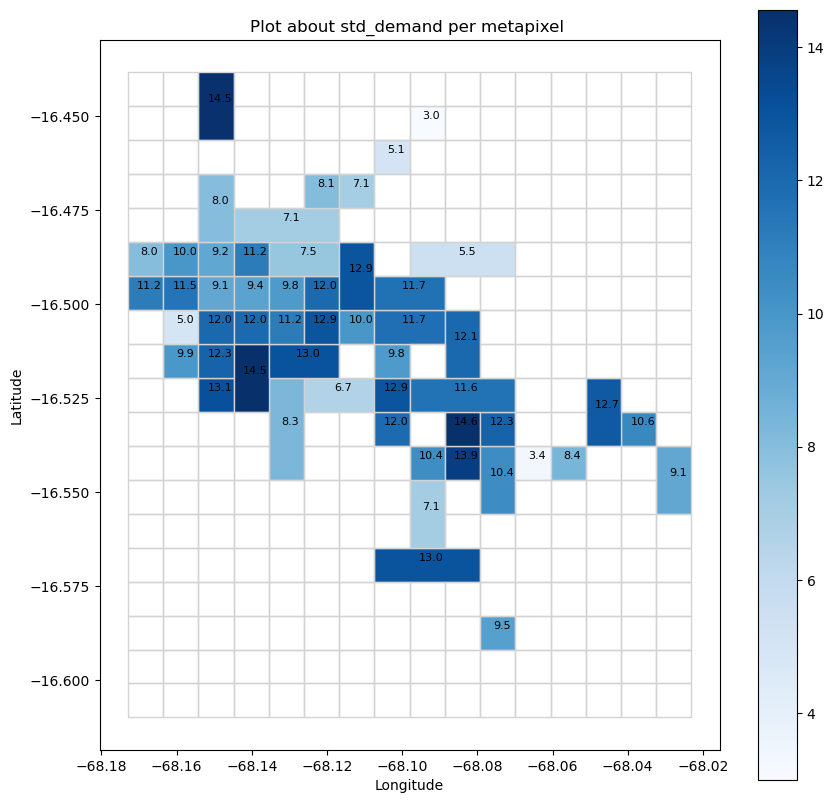

In [20]:
plot_pixels(meta_pixels, 'n_customer', 'customers per metapixel')
plot_pixels(meta_pixels, 'demand', "avg_demand per metapixel")
plot_pixels(meta_pixels, 'std', 'std_demand per metapixel')

### Exportar

In [21]:
output = {
    "id":[],
    "centroid_x": [],
    "cenotrid_y": [],
    "demand": [],
    "n_customer": [],
    "area":[],
}
for mp in meta_pixels:
    output["id"].append(f"{LAYER_SELECTED}-{mp.id}")
    output["centroid_x"].append(mp.get_polygon().centroid.x)
    output["cenotrid_y"].append(mp.get_polygon().centroid.y)
    output["demand"].append(mp.get_avg_demand())
    output["n_customer"].append(mp.get_n_customers())
    output['area'].append(mp.area)

df_output = pd.DataFrame.from_dict(output)

In [23]:
df_output.to_csv(f"../data/output_{LAYER_SELECTED}_pixel_aggregation_process.csv", index=False)